In [408]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import seaborn as sns
import pickle
#import descartes
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [409]:
# Loading the accident data of Seattle city
df = gpd.read_file('https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.geojson')


In [410]:
# saving the traffic accident data in a pickle file
df.to_pickle('acc_data.pickle')

In [4]:
df.shape

(207305, 39)

In [5]:
df.columns

Index(['OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE',
       'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE',
       'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES',
       'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR', 'geometry'],
      dtype='object')

In [6]:
df.head(3)

,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,...,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,geometry
0,1001,305831,307111,E850947,Matched,Intersection,32672.0,RAINIER AVE S AND S CHARLESTOWN ST,,None,...,Daylight,None,None,None,15,From same direction - one left turn - one stra...,0,0,N,POINT (-122.29069886527 47.56977061348821)
1,1002,305830,307110,E851648,Matched,Block,NaN,NE 145TH ST BETWEEN 15TH AVE NE AND 17TH AVE NE,,None,...,Daylight,None,None,None,23,From same direction - all others,0,0,N,POINT (-122.3113996469704 47.73393649650035)
2,1003,305829,307109,E850945,Matched,Intersection,31402.0,M L KING JR WAY S AND S MASSACHUSETTS ST,,None,...,Daylight,None,None,None,10,Entering at angle,0,0,N,POINT (-122.2980506522027 47.58831183204907)


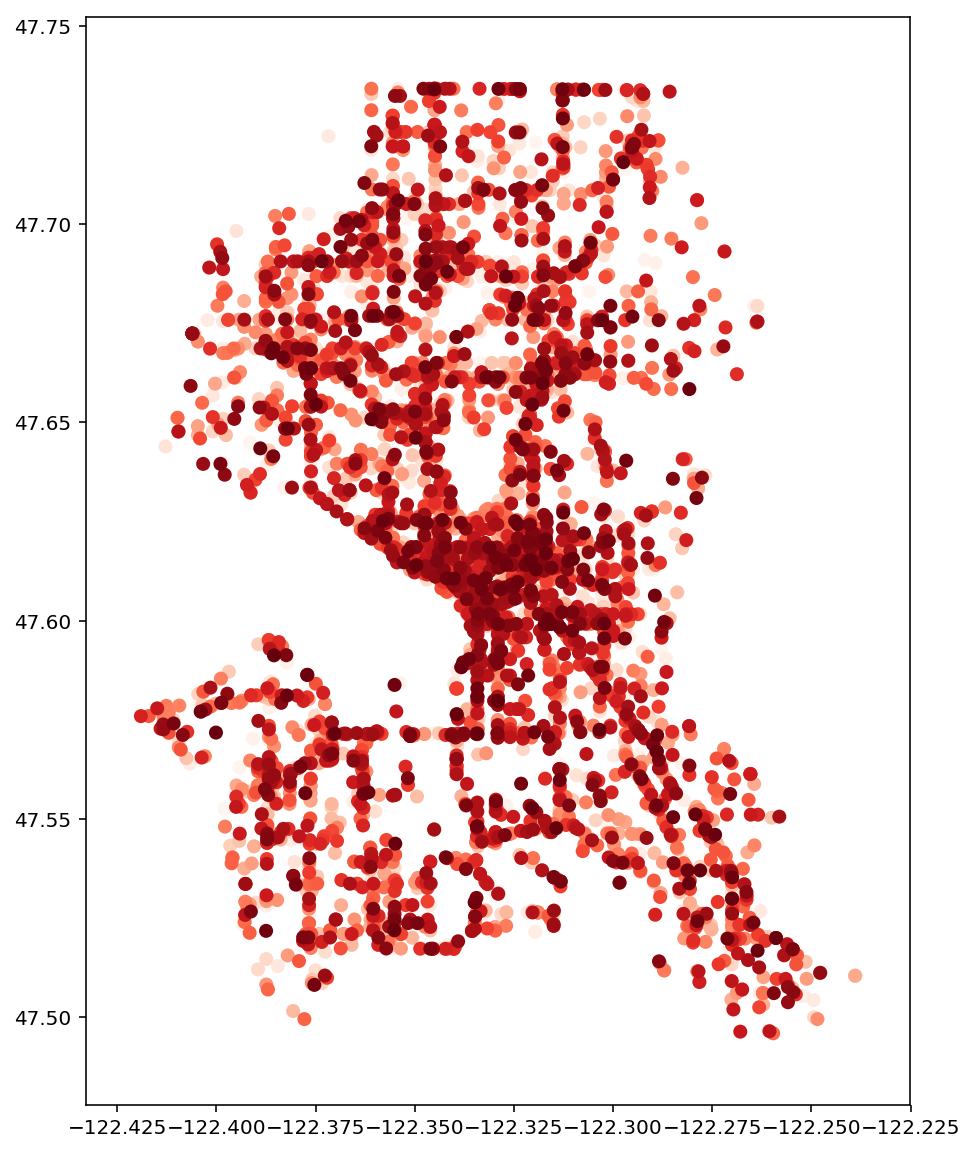

In [8]:
df[df['UNDERINFL'] == 'Y'].plot(cmap = 'Reds', figsize = (12, 10))

In [9]:
df['INCDATE'].unique()

array(['2018-10-20T00:00:00', '2018-10-18T00:00:00',
       '2018-09-25T00:00:00', ..., '2019-01-14T00:00:00',
       '2019-01-13T00:00:00', '2018-12-08T00:00:00'], dtype=object)

In [199]:
df['INTKEY'].unique()

array([33048., 29736.,    nan, ..., 25180., 26718., 33948.])

In [39]:
df['JUNCTIONTYPE'].unique()

array(['At Intersection (intersection related)',
       'Mid-Block (not related to intersection)', None,
       'Mid-Block (but intersection related)',
       'At Intersection (but not related to intersection)',
       'Driveway Junction', 'Ramp Junction', 'Unknown'], dtype=object)

In [10]:
# Extracting the possible features that will be used in the model
new_df = df[['OBJECTID','ADDRTYPE', 'LOCATION','SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT',
'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'UNDERINFL', 'WEATHER', 'ROADCOND',
'LIGHTCOND', 'HITPARKEDCAR','geometry']]

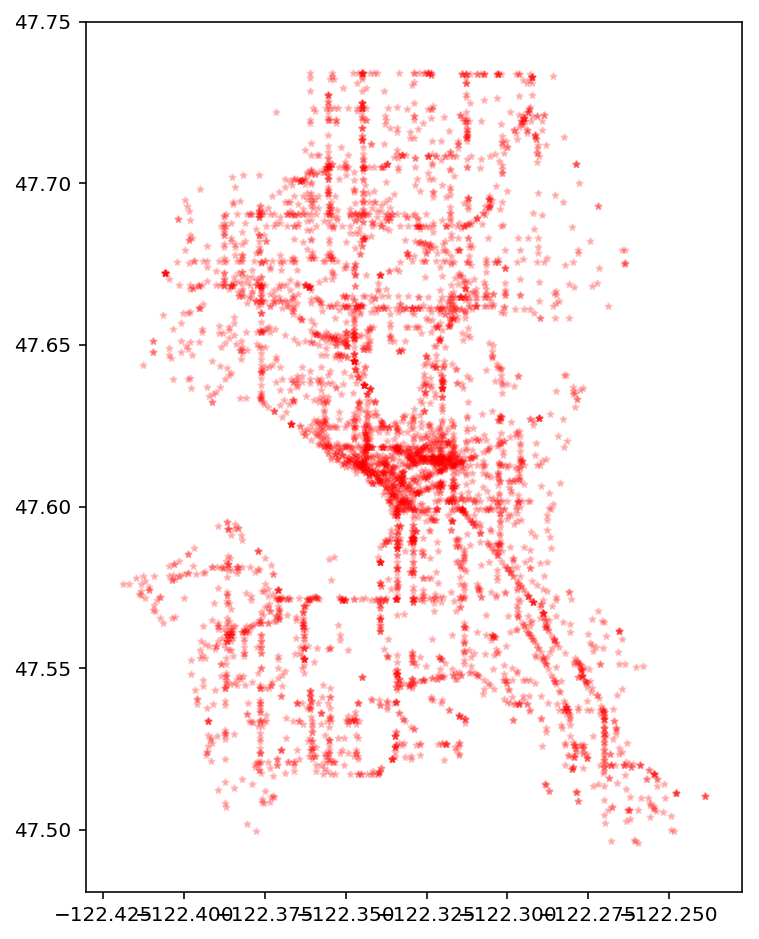

In [11]:
new_df[new_df['UNDERINFL']=='Y'].plot(figsize = (12,8), marker = '*', markersize = 10, facecolor = 'red',alpha = 0.2)

In [12]:
new_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 207305 entries, 0 to 207304
Data columns (total 22 columns):
OBJECTID           207305 non-null int64
ADDRTYPE           203691 non-null object
LOCATION           202874 non-null object
SEVERITYCODE       207304 non-null object
SEVERITYDESC       207305 non-null object
COLLISIONTYPE      183003 non-null object
PERSONCOUNT        207305 non-null int64
PEDCOUNT           207305 non-null int64
PEDCYLCOUNT        207305 non-null int64
VEHCOUNT           207305 non-null int64
INJURIES           207305 non-null int64
SERIOUSINJURIES    207305 non-null int64
FATALITIES         207305 non-null int64
INCDATE            207305 non-null object
INCDTTM            207305 non-null object
JUNCTIONTYPE       196192 non-null object
UNDERINFL          183024 non-null object
WEATHER            182850 non-null object
ROADCOND           182907 non-null object
LIGHTCOND          182758 non-null object
HITPARKEDCAR       207305 non-null object
geometr

In [13]:
new_df.isna().sum()

OBJECTID               0
ADDRTYPE            3614
LOCATION            4431
SEVERITYCODE           1
SEVERITYDESC           0
COLLISIONTYPE      24302
PERSONCOUNT            0
PEDCOUNT               0
PEDCYLCOUNT            0
VEHCOUNT               0
INJURIES               0
SERIOUSINJURIES        0
FATALITIES             0
INCDATE                0
INCDTTM                0
JUNCTIONTYPE       11113
UNDERINFL          24281
WEATHER            24455
ROADCOND           24398
LIGHTCOND          24547
HITPARKEDCAR           0
geometry            7258
dtype: int64

In [15]:
# Converting INCDATE AND INCDTTM to pandas date time columns
new_df.loc[:, 'datetime'] = pd.to_datetime(new_df['INCDATE'])
new_df.loc[:, 'time'] = pd.to_datetime(new_df['INCDTTM'])

In [20]:
new_df.tail()

,OBJECTID,ADDRTYPE,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,...,LIGHTCOND,HITPARKEDCAR,geometry,datetime,time,year,month,day,dayofweek,hour
207300,205996,Block,14TH AVE BETWEEN E PIKE ST AND E PINE ST,0,Unknown,None,0,0,0,0,...,None,Y,POINT (-122.3142331803077 47.61470070819014),2019-01-04,2019-01-04 00:00:00,2019,1,4,4,0
207301,205997,Block,WEST MARGINAL SB WAY S BETWEEN S HOLDEN ST AND...,1,Property Damage Only Collision,Rear Ended,3,0,0,2,...,Daylight,N,POINT (-122.3316798965324 47.53359767877474),2018-11-02,2018-11-02 14:52:00,2018,11,2,4,14
207302,205998,Intersection,STONE WAY N AND N 36TH ST,2,Injury Collision,Angles,2,0,0,2,...,Daylight,N,POINT (-122.3426783613247 47.65053352323068),2018-11-20,2018-11-20 15:02:00,2018,11,20,1,15
207303,205999,Block,BLANCHARD ST BETWEEN 6TH AVE AND 7TH AVE,1,Property Damage Only Collision,Right Turn,3,0,0,2,...,Dark - Street Lights On,N,POINT (-122.3404863326119 47.61626113346894),2018-11-16,2018-11-16 19:15:00,2018,11,16,4,19
207304,206000,Intersection,ROOSEVELT WAY NE AND NE 80TH ST,1,Property Damage Only Collision,Angles,2,0,0,2,...,Daylight,N,POINT (-122.3175526737 47.68673212838139),2018-11-18,2018-11-18 10:35:00,2018,11,18,6,10


In [17]:
# Creating year, month, day, and dayofweek columns
new_df.loc[:,'year'] = pd.DatetimeIndex(new_df['datetime']).year
new_df.loc[:,'month'] = pd.DatetimeIndex(new_df['datetime']).month
new_df.loc[:,'day'] = pd.DatetimeIndex(new_df['datetime']).day
new_df.loc[:,'dayofweek'] = pd.DatetimeIndex(new_df['datetime']).dayofweek

In [18]:
#new_df['year'] = pd.DatetimeIndex(new_df['datetime']).year
new_df.loc[:,'hour'] = pd.DatetimeIndex(new_df['time']).hour

In [19]:
new_df.shape

(207305, 29)

In [21]:
street_map = gpd.read_file('Collisions.shp')

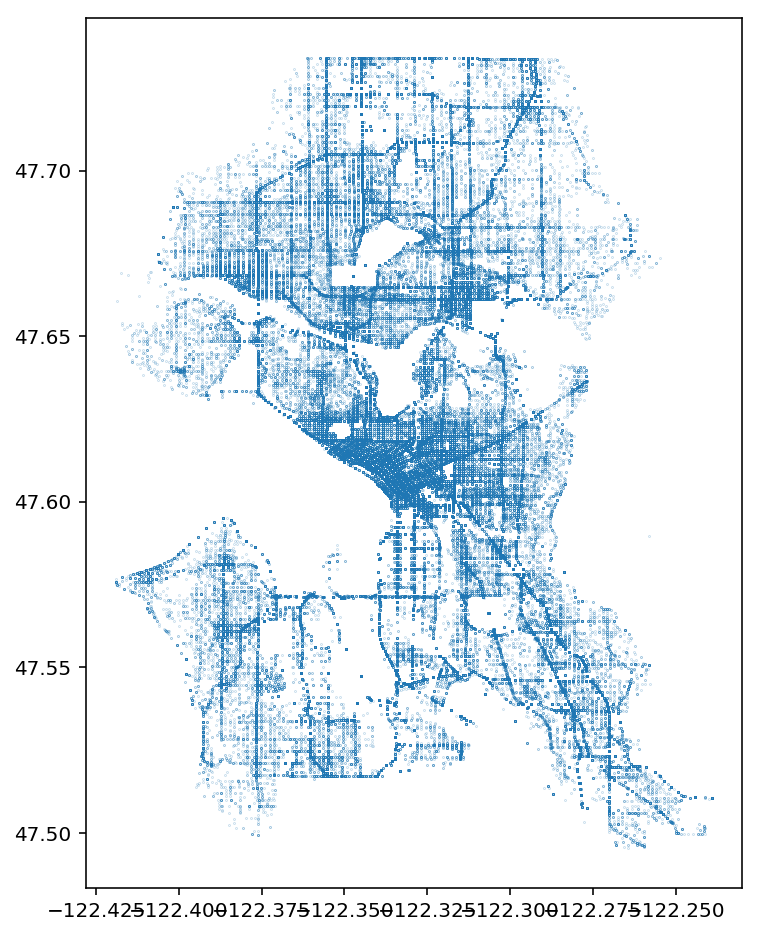

In [22]:
# Accident plot of Seattle city from 2004 to 2019
fig, ax = plt.subplots(figsize=(14, 8))
street_map.plot(ax = ax, markersize = 0.01)

In [73]:
# Coordinate reference system to use geopandas dataframe
# crs = {'init': 'epsg:4326'}

In [72]:
# how to make a Point column (of shapely) in pandas dataframe 
# geometry = [Point(xy) for xy in zip(new_df['X'], new_df['Y'])]

In [74]:
# Creating a new column geometry in pandas dataframe
# geo_df = gpd.GeoDataFrame(new_df, crs = crs, geometry = geometry)


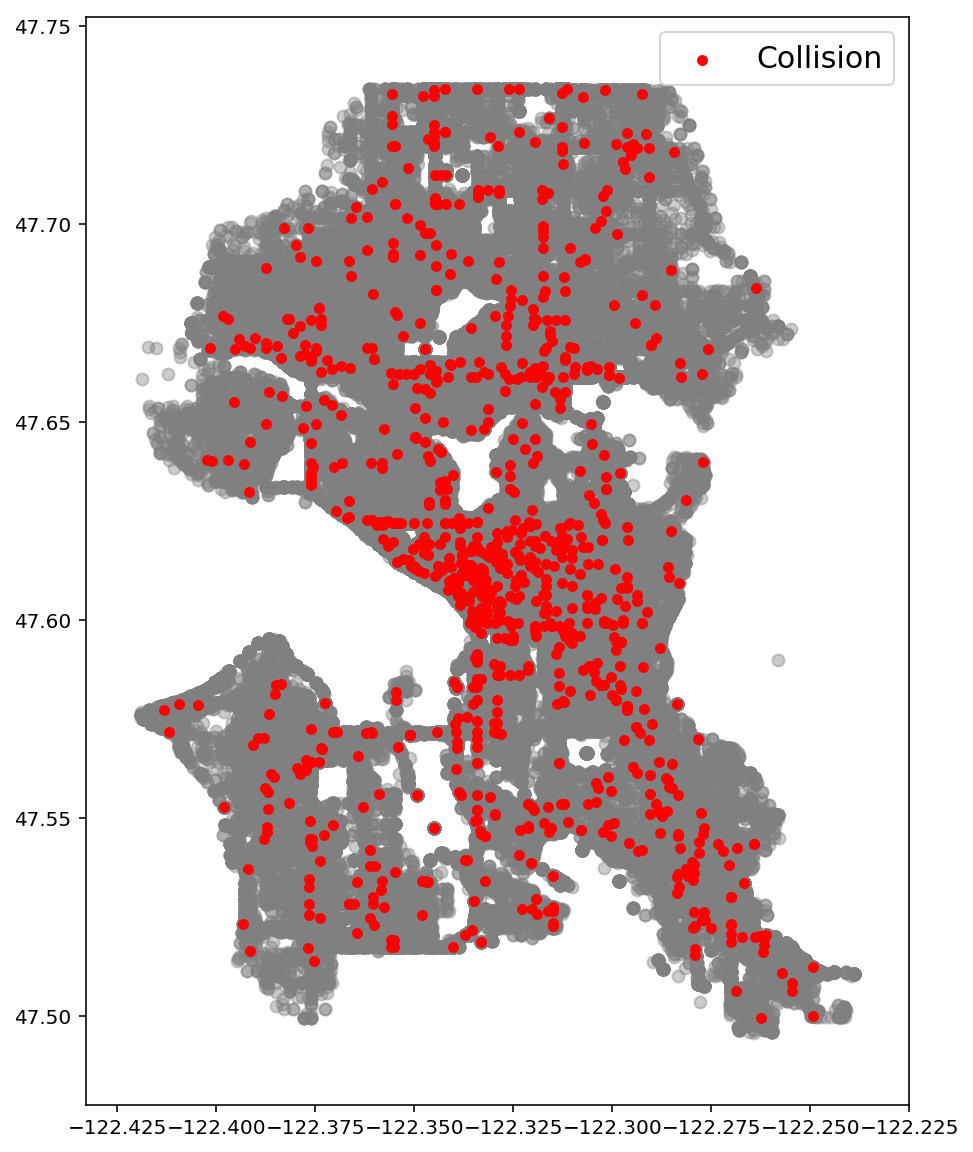

In [239]:
# An example of the plot of some accidents 1000 on the shapefile of Seattle map

fig, ax = plt.subplots(figsize = (12, 10))
street_map.plot(ax = ax, alpha = 0.4, color = 'grey')
new_df[:1000].plot(ax = ax, markersize =20, color = 'red', marker = 'o', label = 'Collision')
plt.legend(prop = {'size':15})

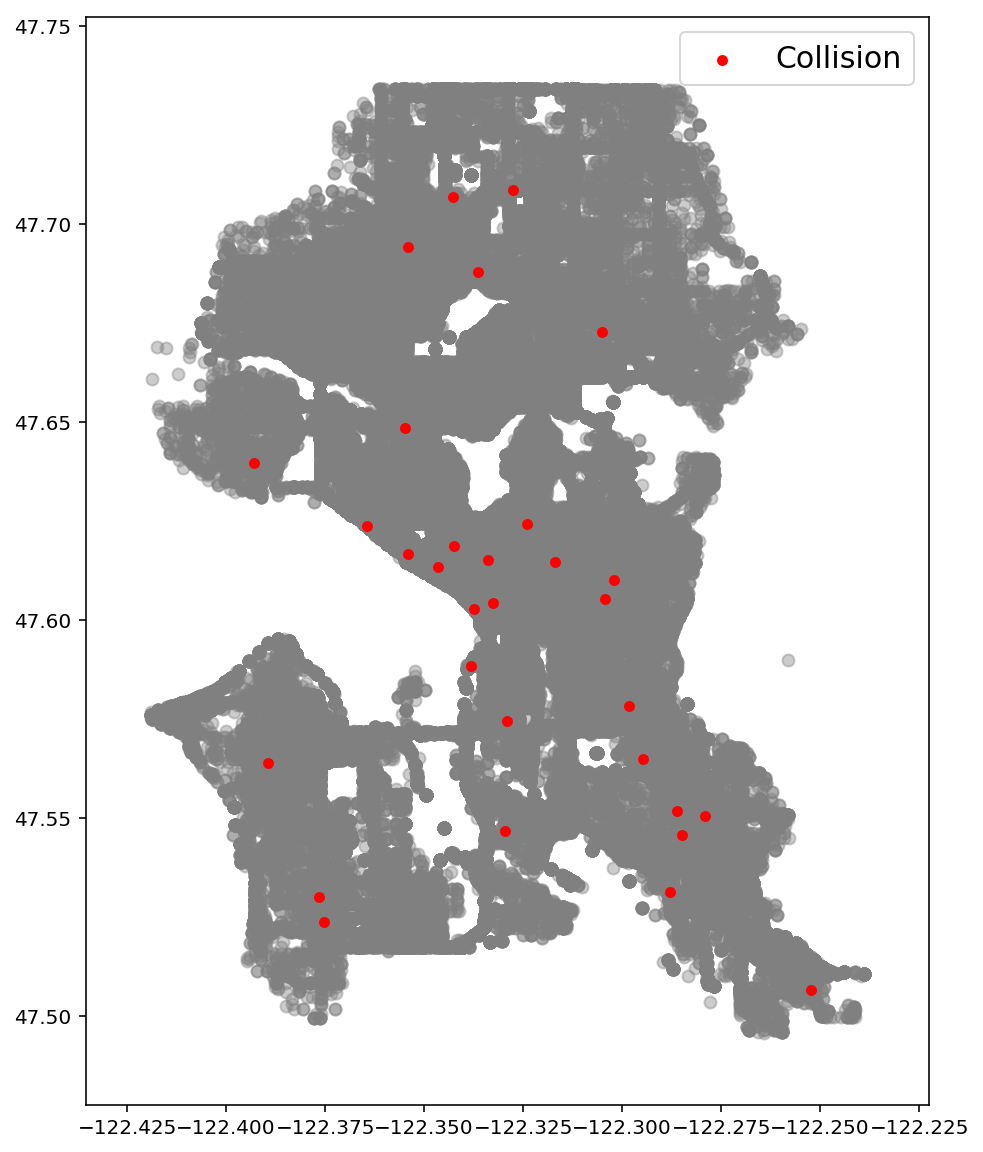

In [118]:
# accident points on New Year's Eve in 2015
fig, ax = plt.subplots(figsize = (8, 10))
new_df.plot(ax = ax, alpha = 0.4, color = 'grey')
new_df[(new_df['year']== 2015) & (new_df['month'] == 12) & (new_df['day']==31)].plot(ax = ax, markersize =20, color = 'red', marker = 'o', label = 'Collision')
plt.legend(prop = {'size':15})

In [25]:
new_df[(new_df['year']== 2018) & (new_df['month'] == 12) & (new_df['day']==31)].shape

(38, 29)

Text(0, 0.5, 'Number of accidents')

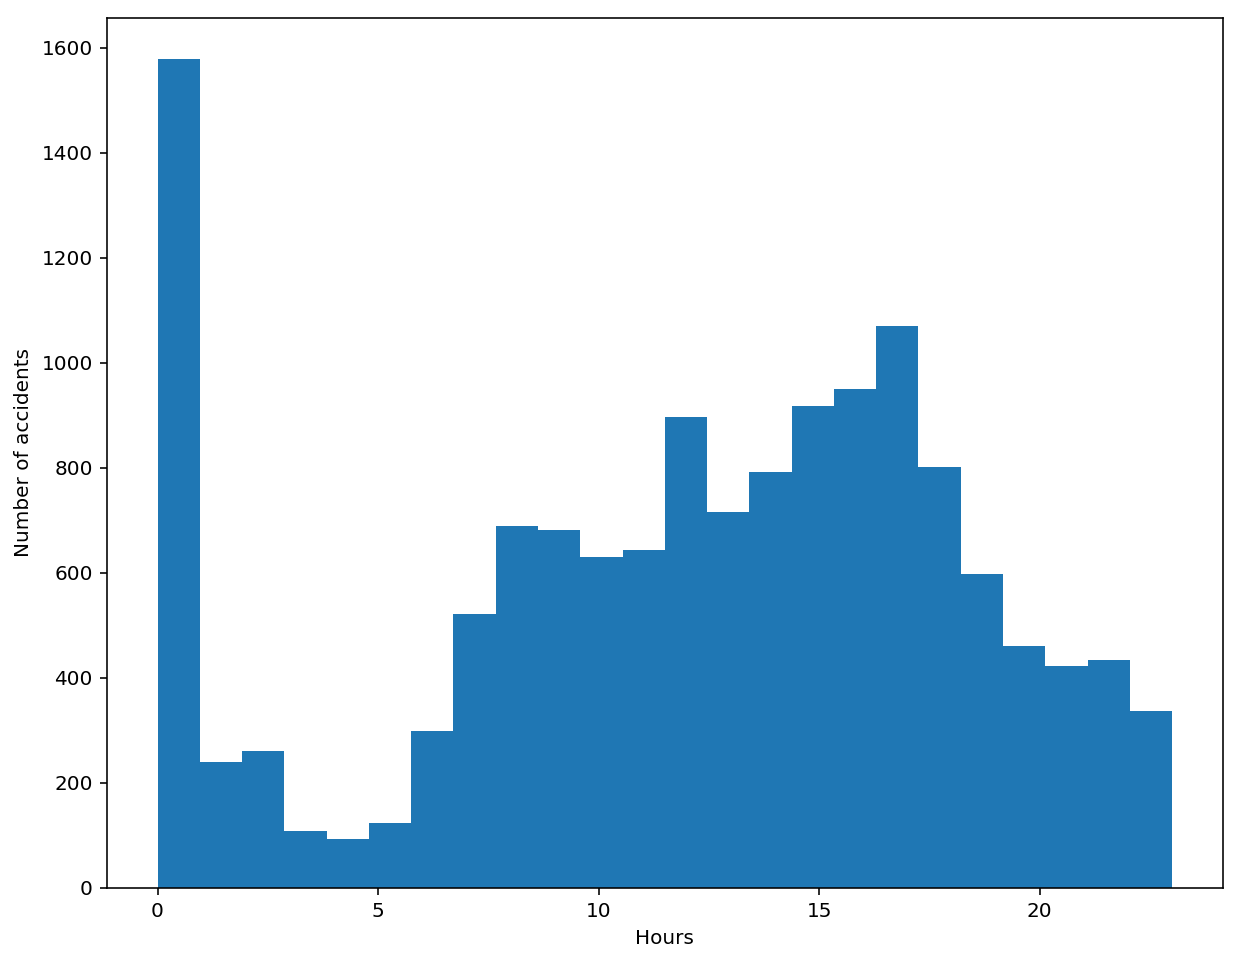

In [26]:
# histogram example of hourly number of accidents in 2015

plt.figure(figsize=(10, 8))
plt.hist(new_df[new_df['year'] == 2015]['hour'], bins = 24)
plt.xlabel('Hours')
plt.ylabel('Number of accidents')

(array([1943.,    0., 2112.,    0., 2100.,    0., 2286.,    0., 2188.,
           0., 2002., 1629.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 12 Patch objects>)

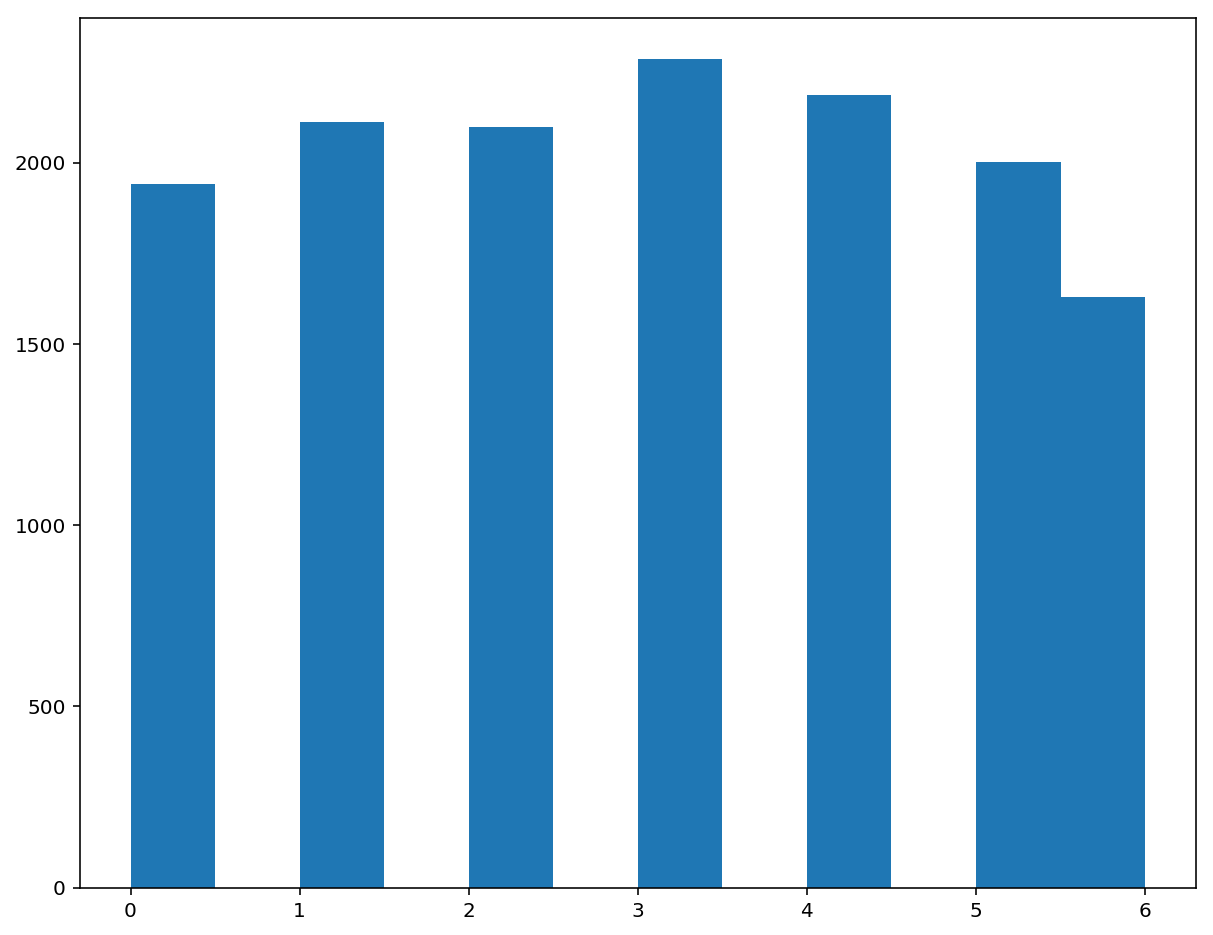

In [27]:
# histogram example of weekly number of accidents in 2015
plt.figure(figsize=(10, 8))
plt.hist(new_df[new_df['year'] == 2015]['dayofweek'], bins = 12)

In [134]:
# Working on time factors
sorted_df = new_df.sort_values('datetime')

In [139]:
time_df = sorted_df.groupby('datetime')['LOCATION'].count()

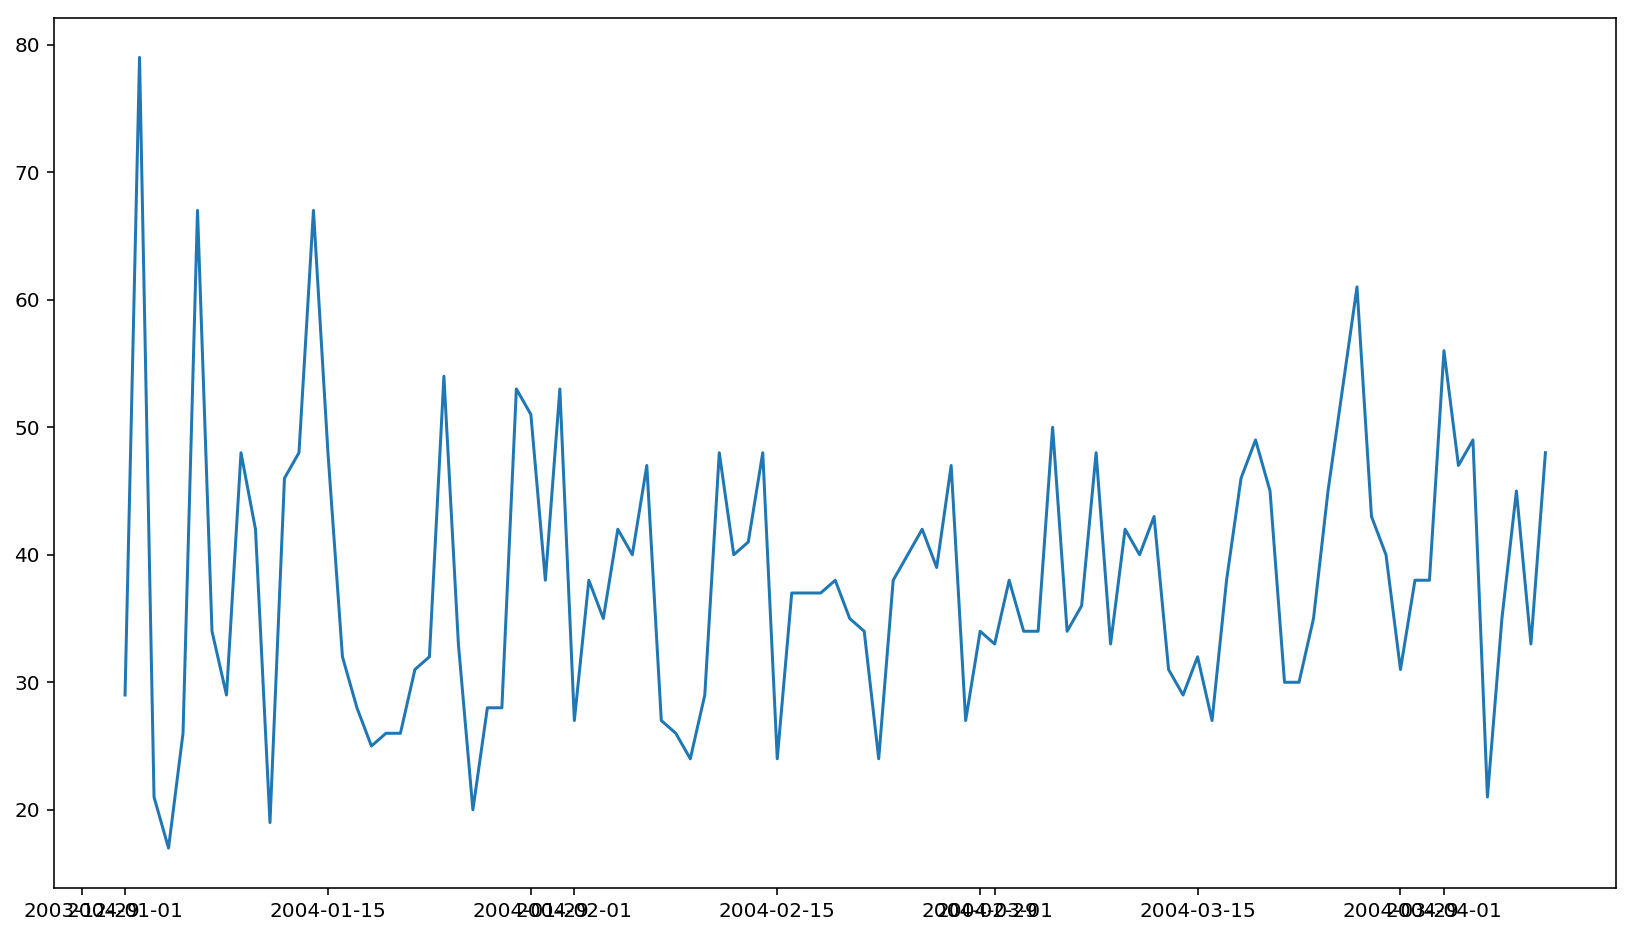

In [145]:
plt.figure(figsize=(14, 8))
plt.plot(time_df[1:100])

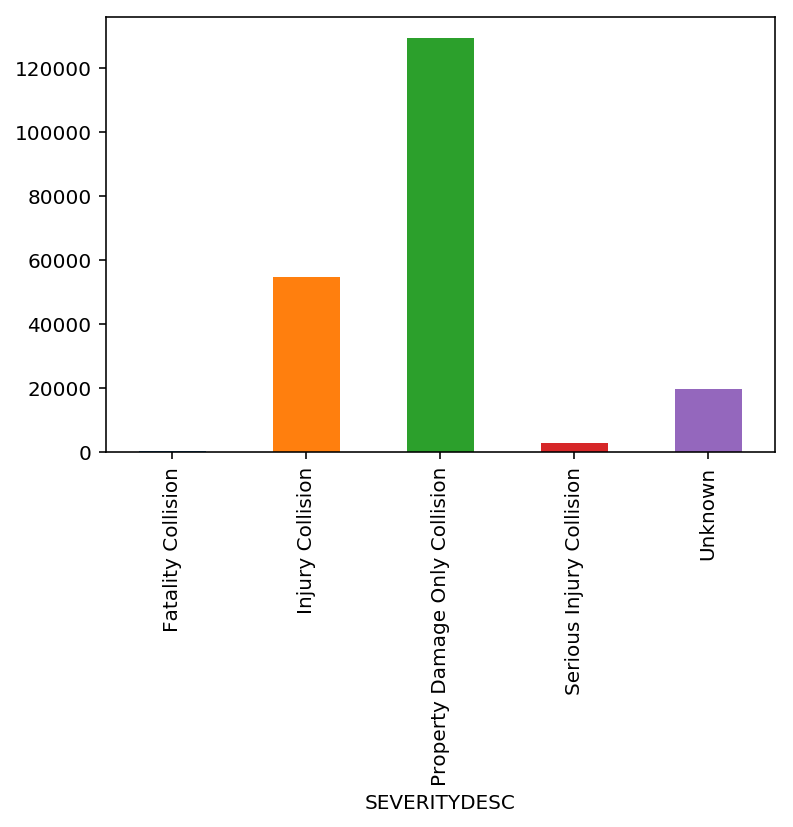

In [28]:
# Some bar plots 

#acc_count = acc.groupby(acc.Accident_Severity).Accident_Severity.count().plot(kind = 'bar')
new_df.groupby(new_df['SEVERITYDESC']).SEVERITYDESC.count().plot(kind = 'bar')

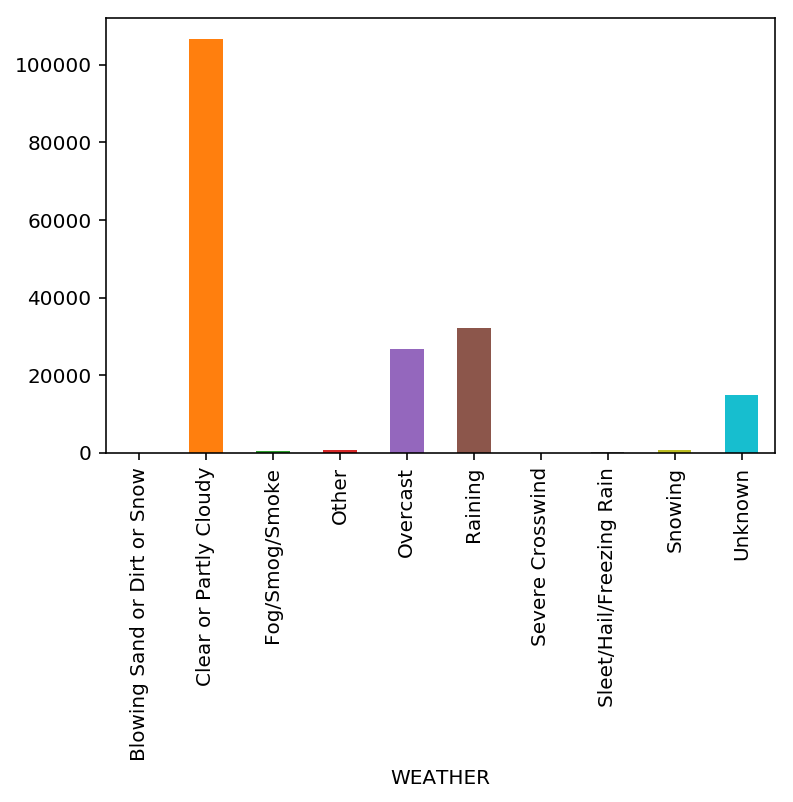

In [29]:
new_df.groupby(new_df['WEATHER']).SEVERITYDESC.count().plot(kind = 'bar')

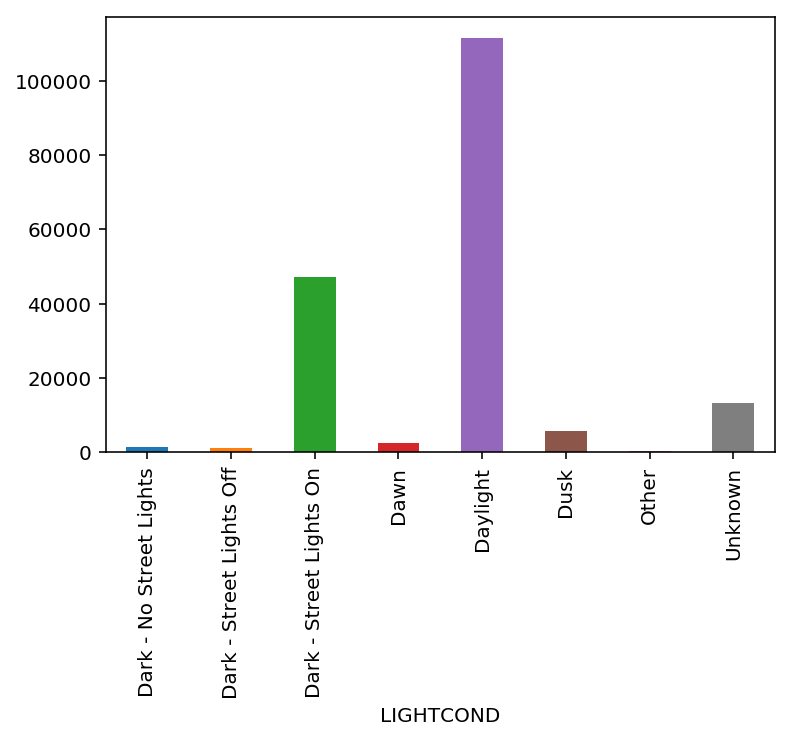

In [30]:
new_df.groupby(new_df['LIGHTCOND']).SEVERITYDESC.count().plot(kind = 'bar')

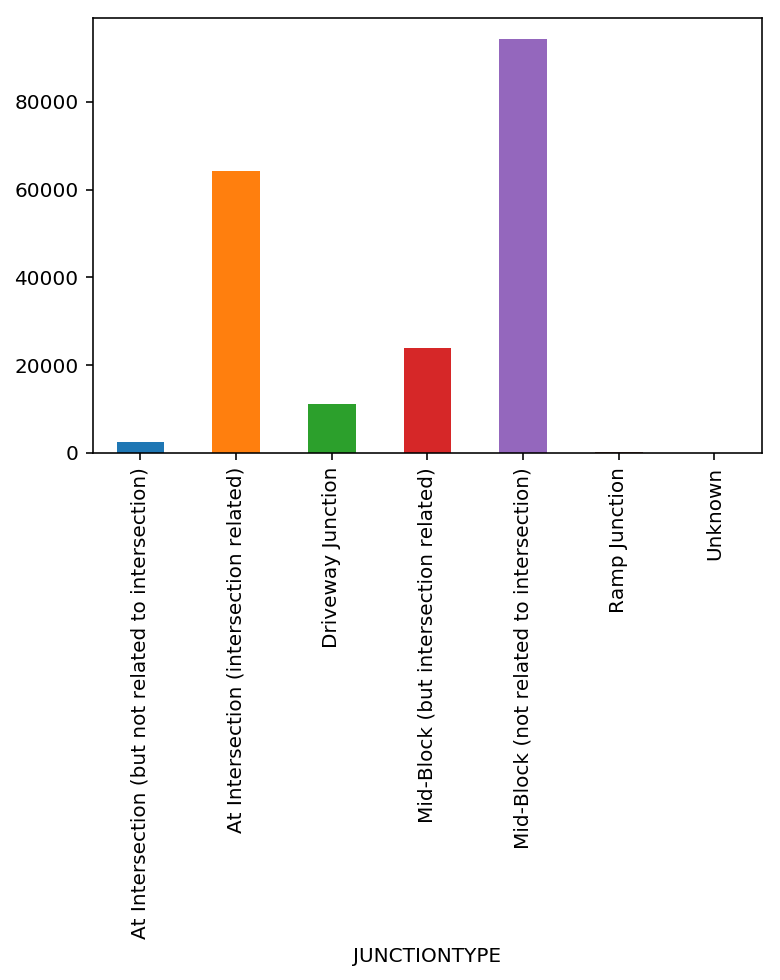

In [31]:
new_df.groupby(new_df['JUNCTIONTYPE']).SEVERITYDESC.count().plot(kind = 'bar')

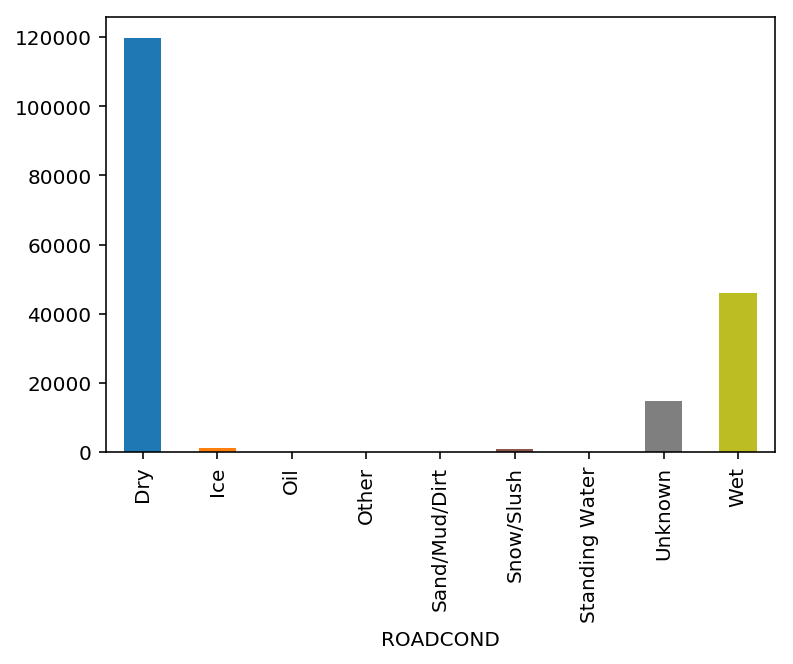

In [32]:
# bar plot of accidents by road conditions
new_df.groupby(new_df['ROADCOND']).SEVERITYDESC.count().plot(kind = 'bar')

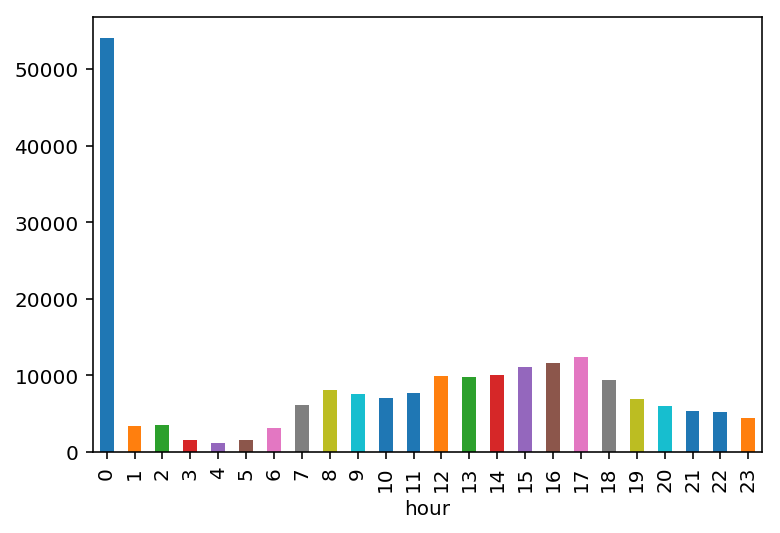

In [33]:
new_df.groupby(new_df['hour']).SEVERITYDESC.count().plot(kind = 'bar')

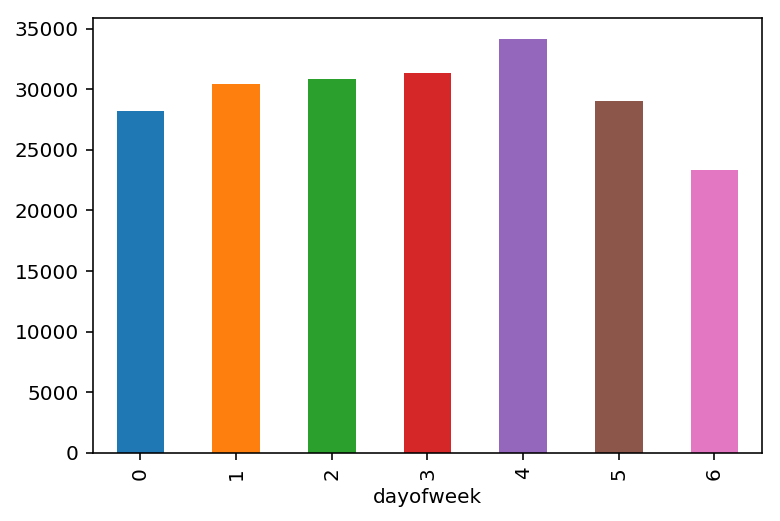

In [34]:
new_df.groupby(new_df['dayofweek']).SEVERITYDESC.count().plot(kind = 'bar')

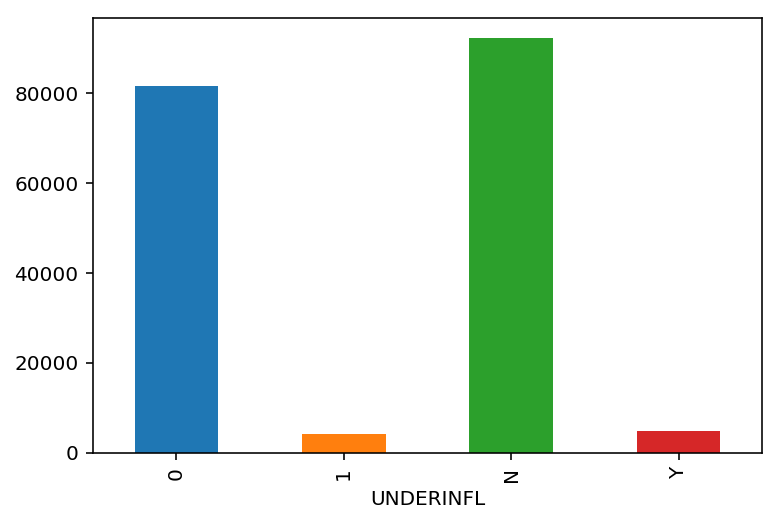

In [35]:
new_df.groupby(new_df['UNDERINFL']).SEVERITYDESC.count().plot(kind = 'bar')

# Loading the traffic flow map volumes of Seattle city
# years are 2007, 2008, 2011, 2012, 2014, 2016

In [37]:
vol_2016 = gpd.read_file('https://opendata.arcgis.com/datasets/170b764c52f34c9497720c0463f3b58b_9.geojson')

In [38]:
vol_2014 = gpd.read_file('https://opendata.arcgis.com/datasets/16cedd233d914118a275c6510115d466_7.geojson')

In [39]:
vol_2011 = gpd.read_file('https://opendata.arcgis.com/datasets/29f801d03c9b4b608bca6a8e497278c3_4.geojson')

In [40]:
vol_2012 = gpd.read_file('https://opendata.arcgis.com/datasets/a0019dd0d6464747a88921f5e103d509_5.geojson')

In [41]:
vol_2007 = gpd.read_file('https://opendata.arcgis.com/datasets/7015d5d46a284f94ac05c2ea4358bcd7_0.geojson')

In [42]:
vol_2008 = gpd.read_file('https://opendata.arcgis.com/datasets/5fc63b2a48474100b560a7d98b5097d7_1.geojson')

# Now we start merging the traffic volume data to the accident data.

In [43]:
acc = new_df.copy()

In [44]:
acc = acc[acc.geometry.notnull()]

In [80]:
acc_2004 = acc[acc['year'] == 2004]
acc_2005 = acc[acc['year'] == 2005]
acc_2006 = acc[acc['year'] == 2006]
acc_2007 = acc[acc['year'] == 2007]
acc_2008 = acc[acc['year'] == 2008]
acc_2009 = acc[acc['year'] == 2009]
acc_2010 = acc[acc['year'] == 2010]
acc_2011 = acc[acc['year'] == 2011]
acc_2012 = acc[acc['year'] == 2012]
acc_2013 = acc[acc['year'] == 2013]
acc_2014 = acc[acc['year'] == 2014]
acc_2015 = acc[acc['year'] == 2015]
acc_2016 = acc[acc['year'] == 2016]
acc_2017 = acc[acc['year'] == 2017]
acc_2018 = acc[acc['year'] == 2018]


In [372]:
# Getting availabe years into one dataframe by concatenating

acc_all = pd.concat([acc_2007,acc_2008, acc_2011, acc_2012, acc_2014, acc_2016])
acc_all.shape


(78373, 29)

In [55]:
# getting the geometry data 
def get_geom(df):
    return df.geometry

In [157]:
# Getting the geometries for available years 
points_2007 = acc_2007.geometry
points_2008 = acc_2008.geometry
points_2011 = acc_2011.geometry
points_2012 = acc_2012.geometry
points_2014 = acc_2014.geometry
points_2016 = acc_2016.geometry
seg_2007 = vol_2007.geometry
seg_2008 = vol_2007.geometry
seg_2011 = vol_2007.geometry
seg_2012 = vol_2007.geometry
seg_2014 = vol_2007.geometry
seg_2016 = vol_2007.geometry

# creating two lists of accident points and road segments

points = [points_2007, points_2008,points_2011,points_2012,points_2014,points_2016]

segments = [seg_2007, seg_2008, seg_2011, seg_2012, seg_2014, seg_2016]



In [47]:
# function to find the minimum distance between each accident point and traffic volume of road segments in traffic volume data
def min_dist(points, linestrings):
    
    dist = []
    for i in points:
        dis = []
        for j in linestrings:
            dis.append(j.distance(i))
        dis= np.array(dis)
        dist.append(dis.argmin())
    return np.array(dist)


In [159]:
# finding all indices of 


"""
need an efficient way!!!
"""
indices = []

for i, j in zip(points, segments):
    indices.append(min_dist(i,j))



6

In [317]:
# We slice annual average daily traffic counts and name of the road segment into a new dataframe
# and set the indices the same as the traffic accident indices

aawdt_2007 = vol_2007[['NAME', 'AAWDT']].iloc[indices[0]]
aawdt_2007['index'] = acc_2007.index
aawdt_2007.set_index('index', inplace=True)

In [382]:
# now we do the above indexing for the rest of the years.

aawdt_2008 = vol_2008[['NAME', 'AAWDT']].iloc[indices[1]]
aawdt_2008['index'] = acc_2008.index
aawdt_2008.set_index('index', inplace=True)

aawdt_2011 = vol_2008[['NAME', 'AAWDT']].iloc[indices[2]]
aawdt_2011['index'] = acc_2011.index
aawdt_2011.set_index('index', inplace=True)

aawdt_2012 = vol_2012[['TITLE', 'RND_AAWDT']].iloc[indices[3]]
aawdt_2012['index'] = acc_2012.index
aawdt_2012.set_index('index', inplace=True)
aawdt_2012.rename({'TITLE': 'NAME', 'RND_AAWDT':'AAWDT' }, axis = 1, inplace = True)

aawdt_2014 = vol_2014[['NAME', 'AAWDT']].iloc[indices[4]]
aawdt_2014['index'] = acc_2014.index
aawdt_2014.set_index('index', inplace=True)

aawdt_2016 = vol_2016[['FIRST_STNAME_ORD', 'AWDT_ROUND']].iloc[indices[5]]
aawdt_2016['index'] = acc_2016.index
aawdt_2016.set_index('index', inplace=True)
aawdt_2016.rename({'FIRST_STNAME_ORD': 'NAME', 'AWDT_ROUND':'AAWDT' }, axis = 1, inplace = True)

In [385]:
# concatenating aawdt dataframes into one dataframe

aawdt_all = pd.concat([aawdt_2007, aawdt_2008, aawdt_2011, aawdt_2012, aawdt_2014, aawdt_2016])

In [413]:
# Joining the final traffic accident data with the final traffic volume data

acc_final = acc_all.join(aawdt_all)
acc_final.to_pickle('acc_final.pickle')

In [414]:
acc_final.head()

,OBJECTID,ADDRTYPE,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,...,geometry,datetime,time,year,month,day,dayofweek,hour,NAME,AAWDT
4093,4094,Block,AURORA AVE N BETWEEN N PHINNEY WAY AND N 46 UP...,1,Property Damage Only Collision,Other,3,0,0,1,...,POINT (-122.3473384928123 47.66144362737841),2007-01-16,2007-01-16 07:37:00,2007,1,16,1,7,"AURORA AVE N, S/O N 80TH ST",40000.0
4222,4223,Block,BELLEVUE AVE E BETWEEN E ROY ST AND BELLEVUE PL E,1,Property Damage Only Collision,Parked Car,2,0,0,2,...,POINT (-122.3265732882878 47.62604179242904),2007-01-31,2007-01-31 19:00:00,2007,1,31,2,19,"EASTLAKE AVE E, SW/O HARVARD AVE E",15800.0
4236,4237,Intersection,LATONA AVE NE AND NE 50TH E ST,1,Property Damage Only Collision,Left Turn,4,0,0,2,...,POINT (-122.3250541588985 47.6649844611938),2007-12-23,2007-12-23 21:00:00,2007,12,23,6,21,"NE 50TH ST, W/O THACKERAY PL NE",27000.0
4244,4245,Block,DENSMORE AVE N BETWEEN N 88TH ST AND N 90TH ST,1,Property Damage Only Collision,Other,1,0,0,1,...,POINT (-122.3378135130007 47.69320803671198),2007-02-20,2007-02-20 01:49:00,2007,2,20,1,1,"N 85TH ST, W/O ASHWORTH AVE N",25840.0
4250,4251,Block,E DENNY WAY BETWEEN 11TH AVE AND 12TH AVE,1,Property Damage Only Collision,Parked Car,2,0,0,2,...,POINT (-122.3175646384551 47.61876371596766),2007-03-06,2007-03-06 00:00:00,2007,3,6,1,0,"12TH AVE, N/O E YESLER WAY",12900.0
